In [1]:
# General imports:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Imports for data handling:
from torch.utils.data import DataLoader

# Imports for model training:
import torch
from torch import nn, optim
from torch.nn import Sequential, Linear, ReLU

from util import Timer
from dataset import EarthSystemsDataset

In [2]:
class EarthSystemsNN(nn.Module):
    def __init__(self, sequence):
        super().__init__()
        self.network = sequence

    def forward(self, x):
        return self.network(x)


In [3]:
class Trainer:
    '''
    Helper class for training a model
    '''

    def __init__(self, model, loss_fn, optimizer, dataset,
                 batch_size=1, device='cpu'):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.batch_size = batch_size

        self.cur_epoch = 0

        dataset.train_mode()
        self.dataset = dataset
        self.data_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        print('\nTRAINING OVERVIEW\n-------------------------------')
        print('OPTIMIZER:\n', optimizer, '\n-------------------------------') 
        print('LOSS FUNCTION:\n', loss_fn, '\n-------------------------------')
        print('MODEL ARCHITECTURE:\n', model, '\n-------------------------------')
        print(f'OTHER:')
        print(f'Training with batch size of {batch_size}')
        print(f'Running on device {device}')

        
        print('Ready to train\n')


    

    def train_loop(self):
        '''
        Trains the model for one epoch (a single pass through the data)
        '''
        self.model.train()
        self.dataset.train_mode()
        size, n_batches, batch_size = len(self.data_loader.dataset), len(self.data_loader), self.data_loader.batch_size
        timer = Timer()
       
        for batch, (X, y) in enumerate(self.data_loader):
            self.model.train()
            self.dataset.train_mode()

            pred = self.model(X)
            loss = self.loss_fn(pred, y)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if (batch % 5 == 0 or batch == n_batches-1) and batch > 0:
                loss, current = loss.item(), (batch+1) * batch_size
                elapsed = timer.get(reset=True)
                print(f'Batch {batch+1:>3d}/{n_batches}, loss: {loss:>7f}  [{current:>5d}/{size:>5d}] ({elapsed:.3f}s)', end=' ')

                if self.dataset.val_frac:
                    val_loss = self.get_error('val')
                    print(f'val loss: {val_loss:>7f}', end='')
                print('')

    def get_error(self, subset):
        '''
        Returns the MSE of the model on either the training or validation set
        '''

        self.model.eval()
        if subset == 'val':
            self.dataset.val_mode()
        else:
            self.dataset.train_mode()

        n_batches = len(self.data_loader)
        total_loss = 0.

        with torch.no_grad():
            for X, y in self.data_loader:
                pred = self.model(X)
                total_loss += self.loss_fn(pred, y).item()
        self.model.train()
        self.dataset.train_mode()
        return total_loss / n_batches

        
    
    def run_training(self, epochs):
        main_timer, loop_timer = Timer(), Timer()
        print(f'Beginning training from epoch {self.cur_epoch+1} for {epochs} epochs')

        for _ in range(epochs):
            self.cur_epoch += 1
            print(f'Epoch {self.cur_epoch}\n-------------------------------')
            self.train_loop()

            print(f'Took {loop_timer.get(reset=True):.3f}s total\n-------------------------------\n')

        print(f'Took {main_timer.get():.4f} seconds')
        print('Done!')
        
        

        

In [4]:
def sequence1(in_size, label_size):
    layers = [
        Linear(in_size, int((2/3)*in_size)),
        ReLU(),
        Linear(int((2/3)*in_size), int((1/4)*in_size)),
        ReLU(),
        Linear(int((1/4)*in_size), label_size)
    ]

    return Sequential(*layers)

    

In [5]:
torch.set_default_dtype(torch.float64)
data_var_names = ['global_temp', 'electricity', 'co2', 'ch4']
y_vals = ['temp_change']
lags = 15

data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=0.2, lags=lags, mode='ann')
sequence = sequence1(len(data_var_names)*lags, len(y_vals))

model = EarthSystemsNN(sequence)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

trainer = Trainer(model, loss_fn, optimizer, dataset=data, batch_size=5)


TRAINING OVERVIEW
-------------------------------
OPTIMIZER:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
) 
-------------------------------
LOSS FUNCTION:
 MSELoss() 
-------------------------------
MODEL ARCHITECTURE:
 EarthSystemsNN(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
) 
-------------------------------
OTHER:
Training with batch size of 5
Running on device cpu
Ready to train



In [6]:
trainer.run_training(150)

Beginning training from epoch 1 for 150 epochs
Epoch 1
-------------------------------
Batch   6/75, loss: 439.741716  [   30/  371] (0.158s) val loss: 385.897247
Batch  11/75, loss: 122.117010  [   55/  371] (0.062s) val loss: 109.389920
Batch  16/75, loss: 8.638813  [   80/  371] (0.064s) val loss: 71.731706
Batch  21/75, loss: 21.882242  [  105/  371] (0.056s) val loss: 2.996177
Batch  26/75, loss: 35.224800  [  130/  371] (0.056s) val loss: 2.921122
Batch  31/75, loss: 27.155056  [  155/  371] (0.056s) val loss: 29.430681
Batch  36/75, loss: 1.418095  [  180/  371] (0.064s) val loss: 1.143379
Batch  41/75, loss: 4.413783  [  205/  371] (0.061s) val loss: 11.681340
Batch  46/75, loss: 6.745827  [  230/  371] (0.069s) val loss: 2.005376
Batch  51/75, loss: 3.584472  [  255/  371] (0.062s) val loss: 8.101858
Batch  56/75, loss: 3.399726  [  280/  371] (0.061s) val loss: 4.200867
Batch  61/75, loss: 12.819886  [  305/  371] (0.063s) val loss: 5.025219
Batch  66/75, loss: 12.419498  [  

In [7]:
trainer.get_error('train')

0.03526796062918393

In [8]:
with torch.no_grad():
    pred_loader = DataLoader(data, batch_size=1, shuffle=False)
    pred = ([0.]*lags) + [model(X) for X, y in pred_loader]

C:\Users\keena\AppData\Roaming\Python\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


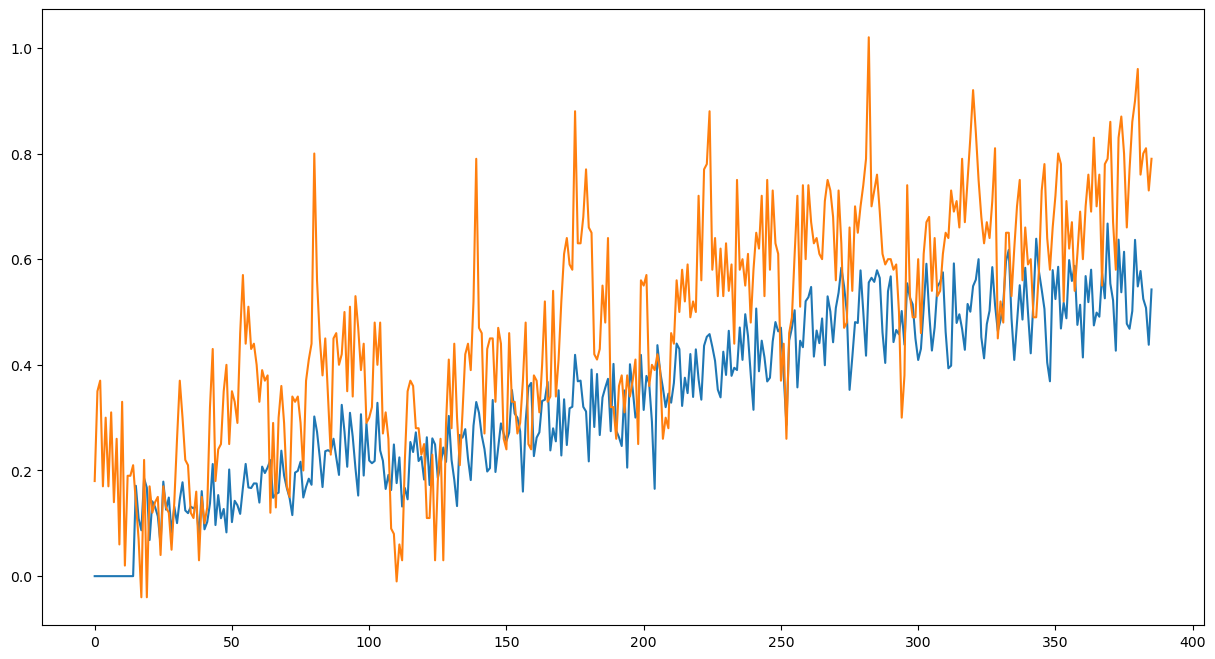

In [9]:
plt.figure(figsize=(15,8))
plt.plot(pred)
plt.plot(data.data.reset_index()[y_vals[0]])

In [27]:
data.data.head(20)

temp_change  elec_generation  co2_average  ch4_average
year month                                                        
1983 Jul           0.18          220.447       342.14      1625.94
     Aug           0.35          230.193       340.62      1628.06
     Sep           0.37          195.817       340.53      1638.44
     Oct           0.17          183.137       341.75      1644.79
     Nov           0.30          183.171       342.83      1642.60
     Dec           0.17          212.555       343.49      1639.57
1984 Jan           0.31          216.924       344.32      1638.76
     Feb           0.14          189.810       344.82      1638.84
     Mar           0.26          200.387       344.96      1640.84
     Apr           0.06          181.381       345.19      1643.96
     May           0.33          192.550       345.33      1643.13
     Jun           0.02          209.967       344.57      1639.74
     Jul           0.19          221.526       343.20      1637.97
     Aug           0.19          229.532       342.21      1641.68
     Sep           0.21          195.411       342.13      1650.63
     Oct           0.14          191.142       342.99      1654.59
     Nov           0.07          190.602       344.16      1653.79
     Dec          -0.04          200.232       345.00      1656.22
1985 Jan           0.22          228.148       345.35      1655.58
     Feb          -0.04          198.488       345.80      1652.22

## Reccurent Neural Network (RNN)